In [221]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
from tensorflow import keras
from keras.layers import Reshape, Conv2DTranspose, PReLU
from keras.utils import to_categorical, plot_model
from keras.layers import Concatenate
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize
from scipy.linalg import sqrtm
import tensorflow as tf
from IPython.display import clear_output, HTML
import glob
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential, Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from keras.layers import LeakyReLU, GlobalMaxPooling2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import numpy as np
from skimage.transform import AffineTransform, warp
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, Reshape, UpSampling2D, \
    BatchNormalization, Activation, Input, LeakyReLU, ZeroPadding2D, Dropout, Flatten, Conv2DTranspose
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import rotate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, Activation, Input, LeakyReLU
from keras.initializers import RandomNormal
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [222]:
# List physical GPUs and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [223]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('emnist-letters-train.csv', delimiter=',', header=None)

In [224]:
df.rename(columns={0: 'labels'}, inplace=True)

In [225]:
df = df[df['labels'] != -1]

In [226]:
# Define the mapping dictionary
mapping = {1: 97, 2: 98, 3: 99, 4: 100, 5: 101, 6: 102, 7: 103, 8: 104, 9: 105, 
           10: 106, 11: 107, 12: 108, 13: 109, 14: 110, 15: 111, 16: 112, 17: 113, 
           18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 120, 25: 121, 
           26: 122, 27: 123}

        # Map the labels column to its corresponding value
df['labels'] = df['labels'].map(mapping)

In [227]:
y = np.array(df.iloc[:,0].values)
X = np.array(df.iloc[:,1:].values)

In [228]:
X = X / 255.0

In [229]:
X = X.reshape(-1,28,28,1)

In [230]:
augmented_images = []
for image in X:
    rotated_image = rotate(image, 90, reshape=False)
    flipped_image = np.flipud(rotated_image)  # Flip vertically
    augmented_images.append(flipped_image)

In [231]:
X = np.array(augmented_images)

In [232]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [233]:
MODEL_OUTPUT_PATH = '/kaggle/working/'
LATENT_DIM = 100

def define_generator():
    """
    Defines the generator model for generating images.

    Returns:
    - tf.keras.models.Model: Generator model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128*7*7, activation='relu', input_dim=LATENT_DIM),
        tf.keras.layers.Reshape((7, 7, 128)),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(momentum=0.8),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(momentum=0.8),
        tf.keras.layers.Conv2D(1, 3, padding='same', activation='tanh')
    ])

    z = tf.keras.layers.Input(shape=(LATENT_DIM,))
    label = tf.keras.layers.Input(shape=(1,), dtype='uint8')
    label_embed = tf.keras.layers.Embedding(input_dim=10, output_dim=LATENT_DIM)(label)
    label_embed = tf.keras.layers.Flatten()(label_embed)
    combined = tf.keras.layers.multiply([z, label_embed])

    img = model(combined)

    return tf.keras.models.Model([z, label], img)

def get_g_model():
    """
    Retrieves the generator model.

    Returns:
    - tf.keras.models.Model: Generator model.
    """
    g_model = define_generator()
    g_model.summary()
    if not os.path.exists(os.path.join(MODEL_OUTPUT_PATH, 'diagrams')): 
        os.makedirs(os.path.join(MODEL_OUTPUT_PATH, 'diagrams'))
    tf.keras.utils.plot_model(
        g_model, to_file=os.path.join(MODEL_OUTPUT_PATH, 'diagrams/generator.png'), show_shapes=True, show_layer_names=True)
    return g_model

g_model = get_g_model()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 100)       1000        ['input_16[0][0]']               
                                                                                                  
 input_15 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 flatten_6 (Flatten)            (None, 100)          0           ['embedding_4[0][0]']            
                                                                                            

In [234]:
def define_discriminator():
    """
    Defines the discriminator model for distinguishing real from fake images.

    Returns:
    - tf.keras.models.Model: Discriminator model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), 2, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, (3, 3), 2, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    img = tf.keras.layers.Input(shape=(28, 28, 1))
    label = tf.keras.layers.Input(shape=(1,))
    label_embed = tf.keras.layers.Embedding(input_dim=10, output_dim=np.prod((28, 28)))(label)
    label_embed = tf.keras.layers.Flatten()(label_embed)
    label_embed = tf.keras.layers.Reshape((28, 28, 1))(label_embed)
    concatenated = tf.keras.layers.Concatenate(axis=-1)([label_embed, img])
    prediction = model(concatenated)
    return tf.keras.models.Model([img, label], prediction)

def get_d_model():
    """
    Retrieves the discriminator model.

    Returns:
    - tf.keras.models.Model: Discriminator model.
    """
    d_model = define_discriminator()
    d_model.summary()
    if not os.path.exists(os.path.join(MODEL_OUTPUT_PATH, 'diagrams')): 
        os.makedirs(os.path.join(MODEL_OUTPUT_PATH, 'diagrams'))
    tf.keras.utils.plot_model(
        d_model, to_file=os.path.join(MODEL_OUTPUT_PATH, 'diagrams/discriminator.png'), show_shapes=True, show_layer_names=True)
    return d_model

d_model = get_d_model()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 784)       7840        ['input_19[0][0]']               
                                                                                                  
 flatten_8 (Flatten)            (None, 784)          0           ['embedding_5[0][0]']            
                                                                                                  
 reshape_5 (Reshape)            (None, 28, 28, 1)    0           ['flatten_8[0][0]']              
                                                                                            

In [235]:
def get_cgan_model():
    """
    Retrieves the CGAN model, discriminator, and generator models.

    Returns:
    - Tuple[tf.keras.models.Model, tf.keras.models.Model, tf.keras.models.Model]: CGAN, discriminator, and generator models.
    """

    d_model.compile(loss='binary_crossentropy', metrics=[
        'accuracy'], optimizer='adam')

    z = tf.keras.layers.Input(shape=(100,))
    label = tf.keras.layers.Input(shape=(1,))
    img = g_model([z, label])

    d_model.trainable = False
    prediction = d_model([img, label])
    cgan = tf.keras.models.Model([z, label], prediction)
    cgan.compile(loss='binary_crossentropy',
                 optimizer='adam', metrics=['accuracy'])
    cgan.summary()
    if not os.path.exists(os.path.join(MODEL_OUTPUT_PATH, 'diagrams')): 
        os.makedirs(os.path.join(MODEL_OUTPUT_PATH, 'diagrams'))
    tf.keras.utils.plot_model(
        cgan, to_file=os.path.join(MODEL_OUTPUT_PATH, 'diagrams/cgan.png'), show_shapes=True, show_layer_names=True)
    return cgan, d_model, g_model

cgan, d_model, g_model = get_cgan_model()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 model_6 (Functional)           (None, 28, 28, 1)    857193      ['input_20[0][0]',               
                                                                  'input_21[0][0]']               
                                                                                                  
 model_7 (Functional)           (None, 1)            1633601     ['model_6[0][0]',          

79920
4/4 [==============================] - 9s 9ms/step
Losses(d,g): 2.964592069387436 [0.2202635407447815, 1.0]
1/1 [==============================] - 0s 280ms/step


c:\Users\user\anaconda3\envs\gpu_env\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


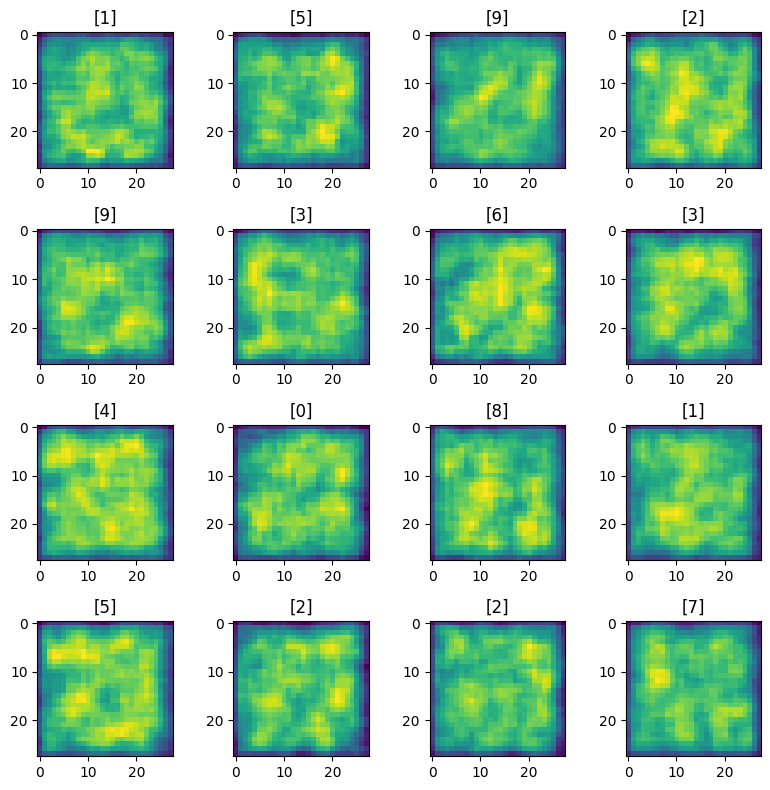

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 4.604577497957507e-06 [12.071405410766602, 0.0]
1/1 [==============================] - 0s 19ms/step


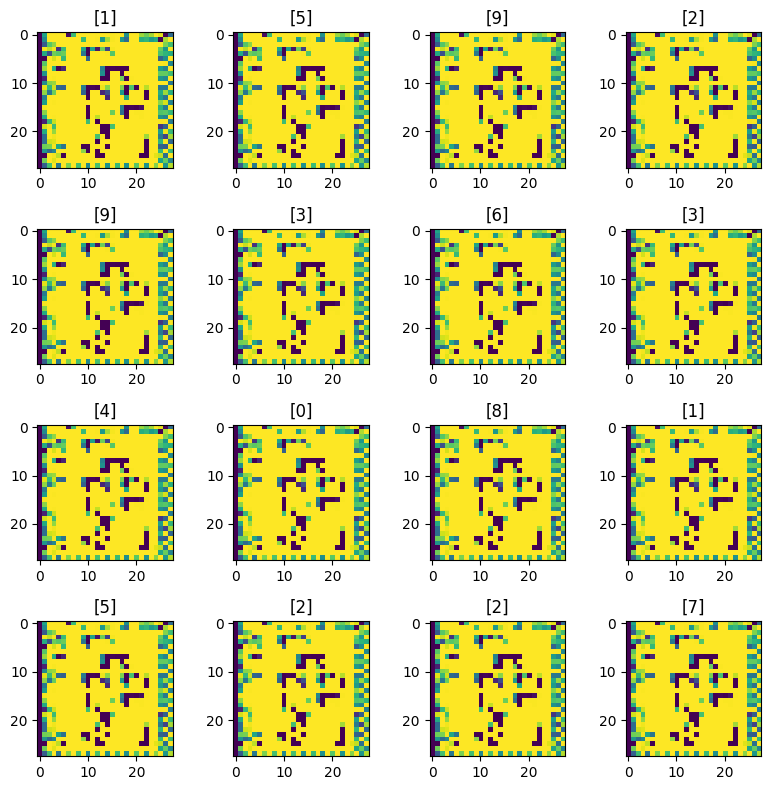

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 1.0277951787429629e-06 [13.937560081481934, 0.0]
1/1 [==============================] - 0s 18ms/step


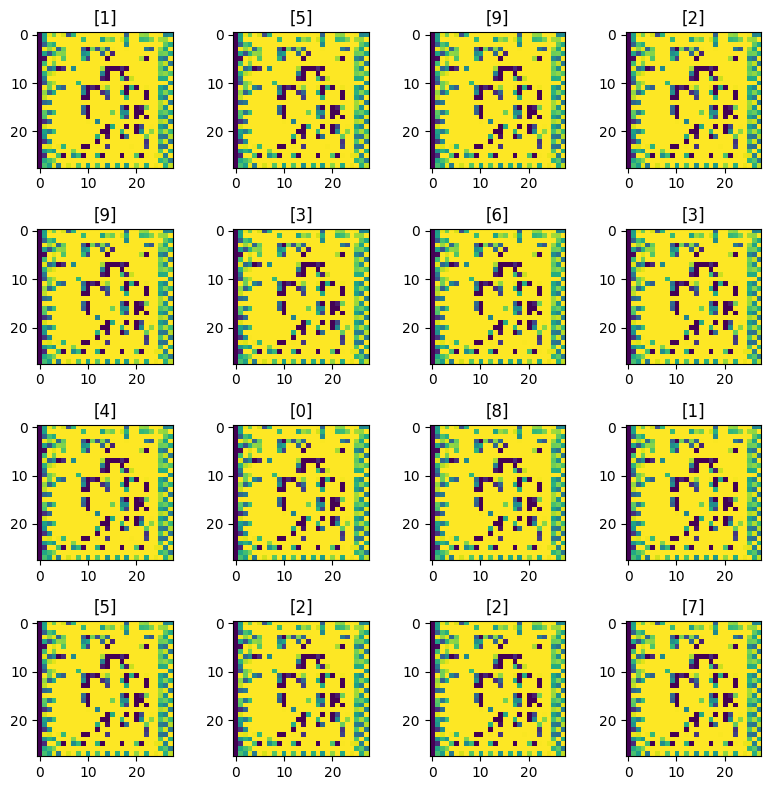

4/4 [==============================] - 0s 4ms/step
Losses(d,g): 2.004657346788008e-07 [15.392396926879883, 0.0]
1/1 [==============================] - 0s 17ms/step


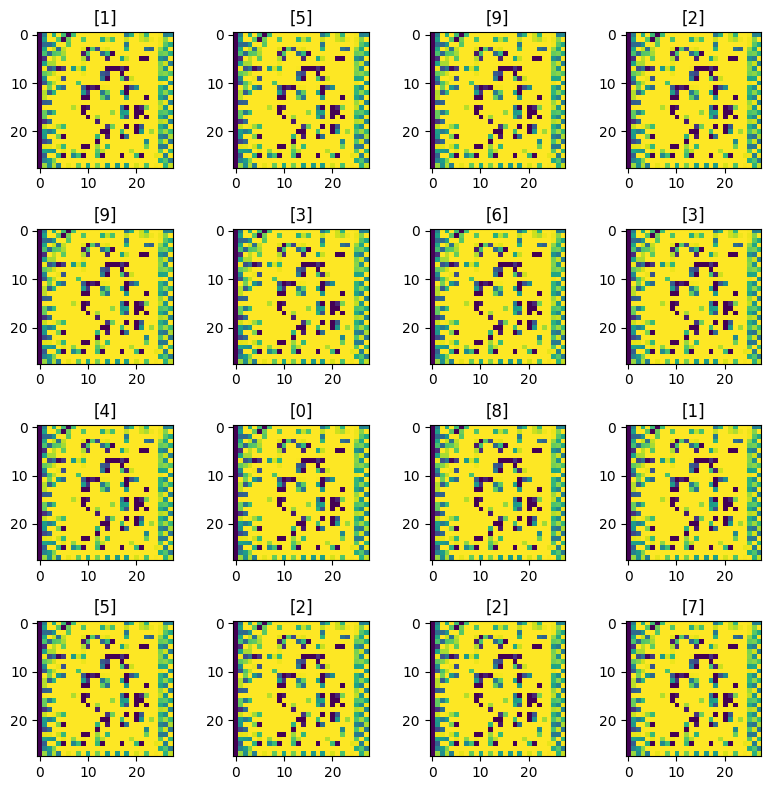

4/4 [==============================] - 0s 4ms/step


KeyboardInterrupt: 

In [236]:
EPOCHS = 15005
BATCH_SIZE = 128
SAVE_INTERVAL = 1000

def plot_image(images, labels, rows, cols):
    """
    Plots images in a grid.

    Parameters:
    - images (np.ndarray): Images to be plotted.
    - labels (np.ndarray): Corresponding labels for each image.
    - rows (int): Number of rows in the grid.
    - cols (int): Number of columns in the grid.
    """
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, cols*rows + 1):
        img = images[i-1]
        ax = fig.add_subplot(rows, cols, i)
        ax.title.set_text(labels[i-1])
        plt.imshow(img.reshape((28, 28)))
    fig.tight_layout()
    plt.show()

def train_model():
    """
    Trains the CGAN model on the MNIST dataset.
    """
    valid = np.ones((BATCH_SIZE, 1))
    fake = np.zeros((BATCH_SIZE, 1))

    losses = {"G": [], "D": []}
    print(y_train.shape[0])
    samples_test = np.random.normal(0, 1, (16, 100))
    labels_test = np.random.randint(0, 10, 16).reshape((-1, 1))

    for epoch in range(EPOCHS):
        idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
        real_imgs, labels = x_train[idx], y_train[idx]

        noise = np.random.normal(0, 1, (BATCH_SIZE, 100))
        fake_imgs = g_model.predict([noise, labels])

        # train discriminator
        d_model.trainable = True
        d_loss_real = d_model.train_on_batch([real_imgs, labels], valid)
        d_loss_fake = d_model.train_on_batch([fake_imgs, labels], fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        d_model.trainable = False

        z = np.random.normal(0, 1, size=(BATCH_SIZE, 100))
        labels = np.random.randint(0, 10, BATCH_SIZE).reshape((-1, 1))

        # train generator
        g_loss = cgan.train_on_batch([z, labels], valid)

        losses["G"].append(g_loss)
        losses["D"].append(d_loss)

        if epoch % SAVE_INTERVAL == 0:
            print("Losses(d,g):", d_loss[0], g_loss)
            results = g_model.predict([samples_test, labels_test])
            plot_image(results, labels_test, 4, 4)
    
    return cgan, d_model, g_model

cgan, d_model, g_model = train_model()
